# Football Player Position Prediction - Model Training

Notebook ini berisi proses training model untuk prediksi posisi pemain sepak bola.

## 1. Import Libraries

In [5]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import joblib
import pickle
import time
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from imblearn.over_sampling import SMOTE

## 2. Configuration

In [6]:
USE_GPU = False
FAST_MODE = True

GPU_AVAILABLE = False
if USE_GPU:
    try:
        import torch
        if torch.cuda.is_available():
            GPU_AVAILABLE = True
            device = torch.device('cuda')
            print(f"GPU detected: {torch.cuda.get_device_name(0)}")
            print(f"CUDA Version: {torch.version.cuda}")
            print(f"Using PyTorch {torch.__version__}")
        else:
            print("PyTorch installed but no CUDA GPU detected")
            device = torch.device('cpu')
    except ImportError:
        print("GPU mode enabled but PyTorch not installed")
        GPU_AVAILABLE = False
        USE_GPU = False
        device = torch.device('cpu')
else:
    GPU_AVAILABLE = False
    print("Running in CPU mode")
    device = None

if FAST_MODE:
    print("FAST MODE enabled (3-fold CV, reduced param grid)")
else:
    print("FULL MODE (5-fold CV, extensive param grid)")

print("="*60)
start_time = time.time()

Running in CPU mode
FAST MODE enabled (3-fold CV, reduced param grid)


## 3. Load Data

In [7]:
print("Loading Data...")
df = pd.read_csv('cleaned_football_data.csv')

df['embedding'] = df['embedding'].apply(lambda x: json.loads(x) if isinstance(x, str) else x)
df['primary_position'] = df['positions'].apply(lambda x: x.split(',')[0] if isinstance(x, str) else x)

print(f"\nData loaded: {len(df)} rows")
print(f"\nFirst player: {df.iloc[0]['full_name']}")
print(f"Original positions: {df.iloc[0]['positions']}")
print(f"Primary position: {df.iloc[0]['primary_position']}")

Loading Data...

Data loaded: 5000 rows

First player: Lionel Andres Messi Cuccittini
Original positions: CF,RW,ST
Primary position: CF

Data loaded: 5000 rows

First player: Lionel Andres Messi Cuccittini
Original positions: CF,RW,ST
Primary position: CF


## 4. Check Class Distribution

Class Distribution:
primary_position
CB     865
ST     740
GK     614
CM     592
CDM    367
RB     357
LB     350
RM     290
LM     283
CAM    277
LW      99
RW      97
CF      26
RWB     23
LWB     20
Name: count, dtype: int64


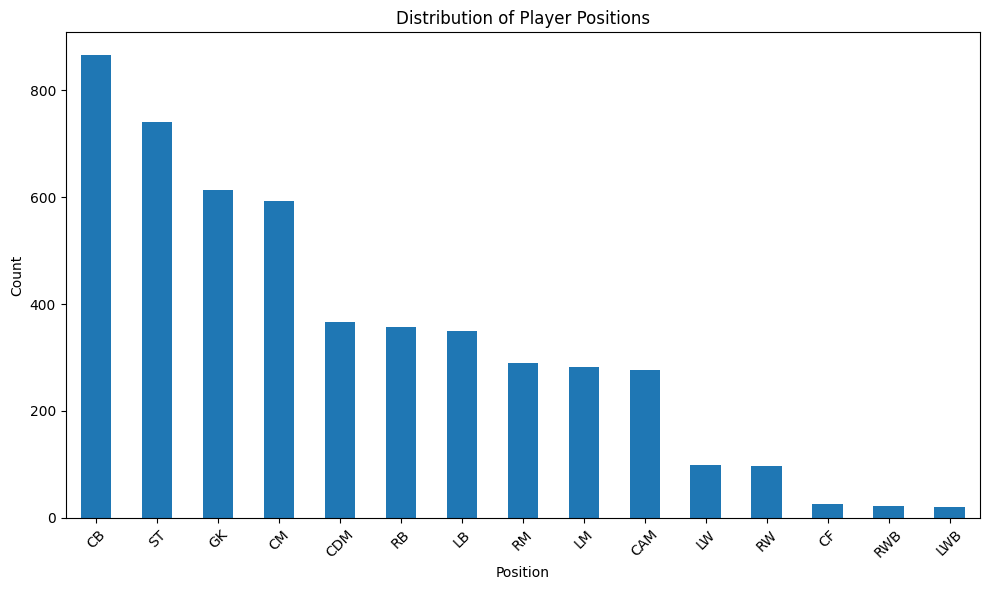

In [8]:
print("Class Distribution:")
print(df['primary_position'].value_counts())

plt.figure(figsize=(10, 6))
df['primary_position'].value_counts().plot(kind='bar')
plt.title('Distribution of Player Positions')
plt.xlabel('Position')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 5. Feature Engineering

In [9]:
print("Feature Engineering...")

# A. Embedding features
X_embedding = pd.DataFrame(df['embedding'].tolist())

# B. Statistical features dari embedding
df['emb_mean'] = df['embedding'].apply(np.mean)
df['emb_std'] = df['embedding'].apply(np.std)
df['emb_max'] = df['embedding'].apply(np.max)
df['emb_min'] = df['embedding'].apply(np.min)
df['emb_range'] = df['emb_max'] - df['emb_min']

# C. Raw statistics (normalized)
stats_cols = ['age', 'acceleration', 'sprint_speed', 'dribbling', 
              'short_passing', 'finishing', 'stamina', 'strength']
X_stats = df[stats_cols].fillna(df[stats_cols].median())

scaler_stats = RobustScaler()
X_stats_scaled = pd.DataFrame(
    scaler_stats.fit_transform(X_stats),
    columns=stats_cols
)

# D. Domain-specific features
df['attack_score'] = (df['finishing'] + df['dribbling'] + df['sprint_speed']) / 3
df['defense_score'] = (df['strength'] + df['stamina']) / 2
df['midfield_score'] = (df['short_passing'] + df['stamina']) / 2
df['speed_score'] = (df['acceleration'] + df['sprint_speed']) / 2
df['technical_score'] = (df['dribbling'] + df['short_passing']) / 2

# E. Aggregate features
emb_stats = df[['emb_mean', 'emb_std', 'emb_max', 'emb_min', 'emb_range']]
domain_features = df[['attack_score', 'defense_score', 'midfield_score', 
                       'speed_score', 'technical_score']]

# F. Combine ALL features
X = pd.concat([
    X_embedding,
    emb_stats.reset_index(drop=True),
    X_stats_scaled.reset_index(drop=True),
    domain_features.reset_index(drop=True)
], axis=1)

X.columns = X.columns.astype(str)

print(f"Total features: {X.shape[1]}")
print(f"  - Embedding: {X_embedding.shape[1]}")
print(f"  - Stats: {len(stats_cols)}")
print(f"  - Engineered: {emb_stats.shape[1] + domain_features.shape[1]}")

Feature Engineering...
Total features: 82
  - Embedding: 64
  - Stats: 8
  - Engineered: 10
Total features: 82
  - Embedding: 64
  - Stats: 8
  - Engineered: 10


## 6. Encode Labels

In [10]:
le = LabelEncoder()
y = le.fit_transform(df['primary_position'])

print(f"Encoded classes: {le.classes_}")
print(f"Number of classes: {len(le.classes_)}")

Encoded classes: ['CAM' 'CB' 'CDM' 'CF' 'CM' 'GK' 'LB' 'LM' 'LW' 'LWB' 'RB' 'RM' 'RW' 'RWB'
 'ST']
Number of classes: 15


## 7. Handle Class Imbalance with SMOTE

In [11]:
print("Handling Class Imbalance with SMOTE...")

class_counts = pd.Series(y).value_counts()
min_class_count = class_counts.min()

if min_class_count >= 6:
    smote = SMOTE(random_state=42, k_neighbors=min(5, min_class_count-1))
    X_resampled, y_resampled = smote.fit_resample(X, y)
    print(f"Original dataset: {X.shape[0]} samples")
    print(f"After SMOTE: {X_resampled.shape[0]} samples")
else:
    X_resampled, y_resampled = X, y
    print(f"Skipping SMOTE (smallest class has {min_class_count} samples)")

Handling Class Imbalance with SMOTE...
Original dataset: 5000 samples
After SMOTE: 12975 samples
Original dataset: 5000 samples
After SMOTE: 12975 samples


## 8. Split Data

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_resampled
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 10380 samples
Test set: 2595 samples


## 9. Model Comparison

In [13]:
cv_folds = 3 if FAST_MODE else 5
print(f"Model Comparison ({cv_folds}-Fold CV)")
print(f"Available CPU cores: {joblib.cpu_count()}")

n_estimators = 100 if FAST_MODE else 200
models = {
    'Random Forest (Tuned)': RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1,
        verbose=0
    ),
    'Random Forest (Simple)': RandomForestClassifier(
        n_estimators=n_estimators,
        random_state=42,
        n_jobs=-1,
        verbose=0
    ),
}

if not FAST_MODE:
    models.update({
        'SVM (RBF)': SVC(
            kernel='rbf', 
            C=10,
            gamma='scale',
            probability=True, 
            random_state=42
        ),
        'KNN': KNeighborsClassifier(
            n_neighbors=7,
            weights='distance',
            metric='minkowski'
        )
    })

results = []
names = []
for name, model in models.items():
    print(f"Training {name}...")
    kfold = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    cv_results = cross_val_score(model, X_resampled, y_resampled, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print(f"  {name}: Accuracy {cv_results.mean():.4f} (+/- {cv_results.std():.4f})")

Model Comparison (3-Fold CV)
Available CPU cores: 8
Training Random Forest (Tuned)...
  Random Forest (Tuned): Accuracy 0.9088 (+/- 0.0039)
Training Random Forest (Simple)...
  Random Forest (Tuned): Accuracy 0.9088 (+/- 0.0039)
Training Random Forest (Simple)...
  Random Forest (Simple): Accuracy 0.9155 (+/- 0.0026)
  Random Forest (Simple): Accuracy 0.9155 (+/- 0.0026)


## 10. Visualize Model Comparison

C:\Users\ACER\AppData\Local\Temp\ipykernel_25852\1549157860.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results, labels=names)


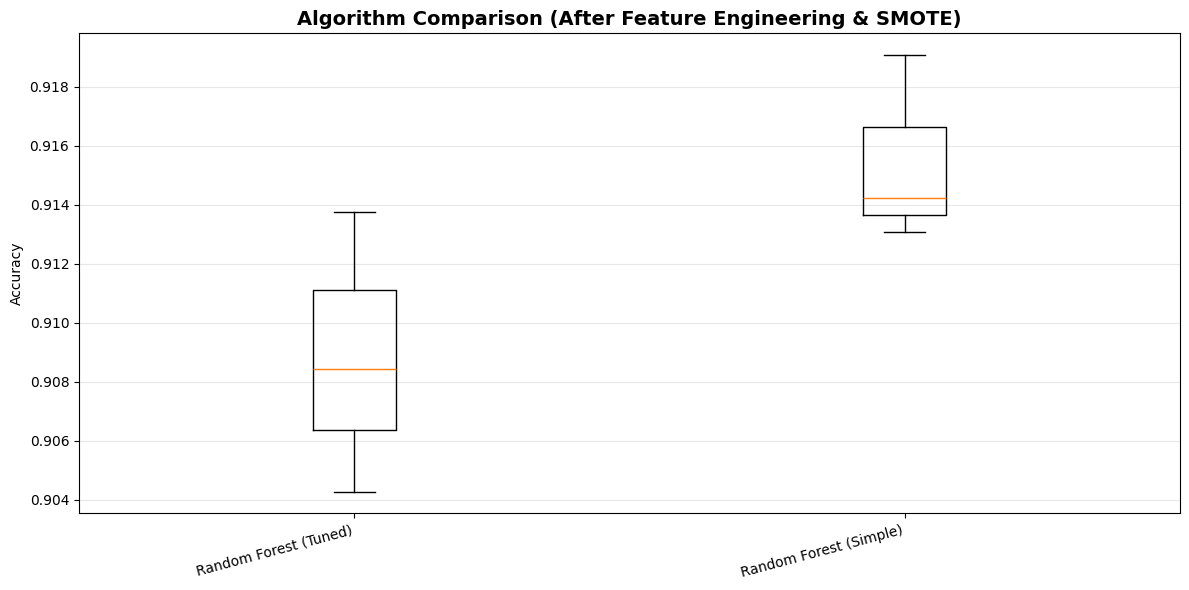

Plot saved as 'model_comparison_plot.png'


In [14]:
plt.figure(figsize=(12, 6))
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison (After Feature Engineering & SMOTE)', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy')
plt.xticks(rotation=15, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('model_comparison_plot.png', dpi=150)
plt.show()

print("Plot saved as 'model_comparison_plot.png'")

## 11. Hyperparameter Tuning

In [15]:
print("Hyperparameter Tuning (Random Forest)")

if FAST_MODE:
    param_grid = {
        'n_estimators': [150, 200],
        'max_depth': [15, 20],
        'min_samples_split': [3, 5],
        'max_features': ['sqrt']
    }
    tuning_cv_folds = 3
    print("FAST MODE: Using reduced parameter grid (3-fold CV)")
else:
    param_grid = {
        'n_estimators': [150, 200, 250],
        'max_depth': [15, 20, 25],
        'min_samples_split': [3, 5, 7],
        'min_samples_leaf': [1, 2, 3],
        'max_features': ['sqrt', 'log2']
    }
    tuning_cv_folds = 5
    print("FULL MODE: Using complete parameter grid (5-fold CV)")

rf_base = RandomForestClassifier(random_state=42, n_jobs=-1, verbose=0)
grid_search = GridSearchCV(
    rf_base, 
    param_grid, 
    cv=tuning_cv_folds, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

print("Searching best parameters...")
grid_search.fit(X_train, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.4f}")

Hyperparameter Tuning (Random Forest)
FAST MODE: Using reduced parameter grid (3-fold CV)
Searching best parameters...
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Best parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 3, 'n_estimators': 200}
Best CV score: 0.9026

Best parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 3, 'n_estimators': 200}
Best CV score: 0.9026


## 12. Final Model Evaluation

In [16]:
print("Training Final Model (Best Random Forest)")
final_model = grid_search.best_estimator_

y_pred = final_model.predict(X_test)
test_score = final_model.score(X_test, y_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

training_time = time.time() - start_time
mins, secs = divmod(training_time, 60)

print(f"\nFinal Test Accuracy: {test_score:.4f}")
print(f"Total Training Time: {int(mins)}m {int(secs)}s")
print(f"Mode: {'FAST' if FAST_MODE else 'FULL'} | {'GPU' if USE_GPU and GPU_AVAILABLE else 'CPU'}")

Training Final Model (Best Random Forest)

Classification Report:
              precision    recall  f1-score   support

         CAM       0.86      0.95      0.90       173
          CB       0.92      0.85      0.89       173
         CDM       0.82      0.88      0.85       173
          CF       0.98      1.00      0.99       173
          CM       0.89      0.76      0.82       173
          GK       1.00      1.00      1.00       173
          LB       0.90      0.95      0.92       173
          LM       0.89      0.88      0.89       173
          LW       0.93      0.99      0.96       173
         LWB       0.98      1.00      0.99       173
          RB       0.88      0.90      0.89       173
          RM       0.95      0.88      0.91       173
          RW       0.97      0.97      0.97       173
         RWB       0.99      1.00      1.00       173
          ST       0.93      0.87      0.90       173

    accuracy                           0.93      2595
   macro avg  

## 13. Feature Importance

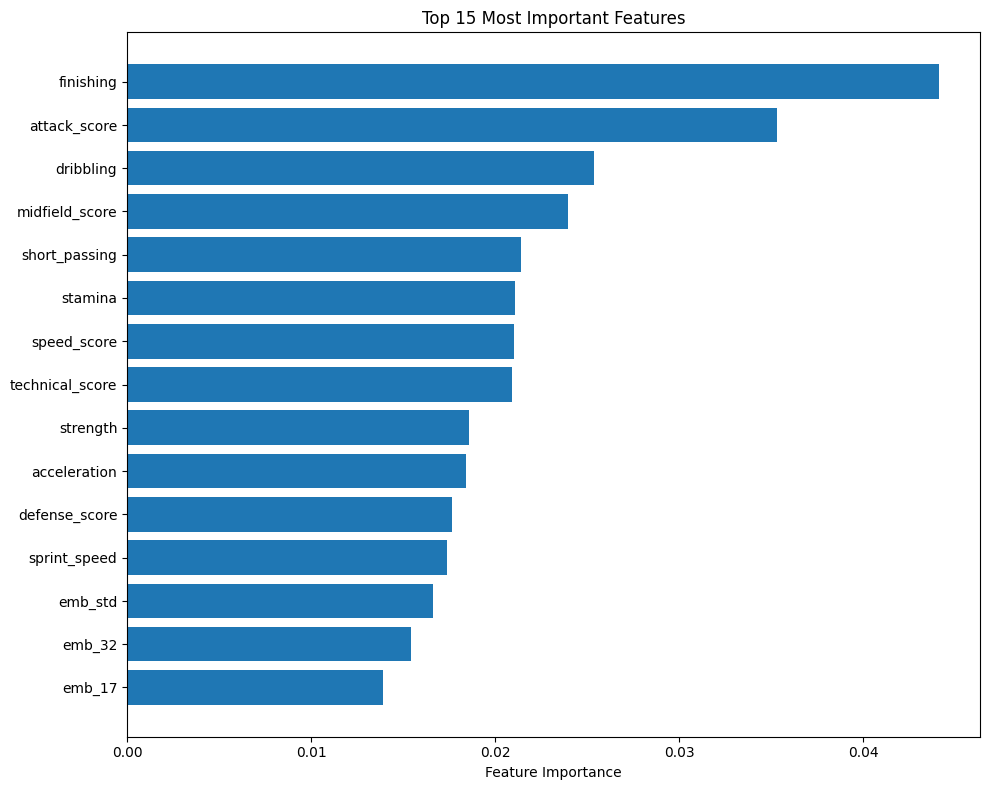

In [17]:
feature_names = (
    [f'emb_{i}' for i in range(X_embedding.shape[1])] +
    ['emb_mean', 'emb_std', 'emb_max', 'emb_min', 'emb_range'] +
    stats_cols +
    ['attack_score', 'defense_score', 'midfield_score', 'speed_score', 'technical_score']
)

importances = final_model.feature_importances_
indices = np.argsort(importances)[-15:]

plt.figure(figsize=(10, 8))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Top 15 Most Important Features')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150)
plt.show()

## 14. Save Model & Artifacts

In [18]:
print("Saving Model & Artifacts")

# Save model
model_filename = 'best_football_model.pkl'
joblib.dump(final_model, model_filename)
print(f"Model saved: {model_filename}")

# Save label encoder
le_filename = 'label_encoder.pkl'
joblib.dump(le, le_filename)
print(f"Label encoder saved: {le_filename}")

# Save scaler
scaler_filename = 'scaler.pkl'
joblib.dump(scaler_stats, scaler_filename)
print(f"Scaler saved: {scaler_filename}")

# Save feature configuration
feature_config = {
    'n_embedding_features': X_embedding.shape[1],
    'stats_cols': stats_cols,
    'use_smote': True,
    'model_type': 'RandomForest',
    'accuracy': float(test_score),
    'cv_score': float(grid_search.best_score_),
    'best_params': grid_search.best_params_,
    'feature_engineering': {
        'embedding_stats': True,
        'normalized_stats': True,
        'domain_features': True
    }
}

config_filename = 'model_config.json'
with open(config_filename, 'w') as f:
    json.dump(feature_config, f, indent=2)
print(f"Config saved: {config_filename}")

print("\nAll artifacts saved successfully!")

Saving Model & Artifacts
Model saved: best_football_model.pkl
Label encoder saved: label_encoder.pkl
Scaler saved: scaler.pkl
Config saved: model_config.json

All artifacts saved successfully!
Model saved: best_football_model.pkl
Label encoder saved: label_encoder.pkl
Scaler saved: scaler.pkl
Config saved: model_config.json

All artifacts saved successfully!
